In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

In [2]:
# 맷플롯립 한글 사용 가능
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 1. 구별 버스정류장 갯수

### 1-1. 서울시 구 경계 데이터 확인

In [3]:
gdf = gpd.read_file \
    ('../4.Public_transportation/LARD_ADM_SECT_SGG_gu/LARD_ADM_SECT_SGG_11_202405.shp')

# 데이터 기본 정보 확인
print("데이터 형태:", gdf.shape)
print("/n컬럼 목록:")
print(gdf.columns)

# 처음 몇 행 출력
print("/n데이터 미리보기:")
print(gdf.head())

# 좌표계 정보
print("/n좌표계 정보:")
print(gdf.crs)

# 지리적 범위
print("/n지리적 범위:")
print(gdf.total_bounds)

데이터 형태: (25, 5)
/n컬럼 목록:
Index(['ADM_SECT_C', 'SGG_NM', 'SGG_OID', 'COL_ADM_SE', 'geometry'], dtype='object')
/n데이터 미리보기:
  ADM_SECT_C     SGG_NM  SGG_OID COL_ADM_SE  \
0      11110  서울특별시 종로구     11.0      11110   
1      11140   서울특별시 중구     34.0      11140   
2      11170  서울특별시 용산구      1.0      11170   
3      11200  서울특별시 성동구      1.0      11200   
4      11215  서울특별시 광진구     49.0      11215   

                                            geometry  
0  POLYGON ((197799.999 559069.695, 197785.848 55...  
1  POLYGON ((202072.448 552243.432, 202072.646 55...  
2  POLYGON ((197569.650 550564.919, 197580.635 55...  
3  POLYGON ((203845.364 552528.280, 203846.364 55...  
4  POLYGON ((208984.357 552552.194, 209038.174 55...  
/n좌표계 정보:
PROJCS["Korea_2000_Korea_Central_Belt_2010",GEOGCS["GCS_Korea_2000",DATUM["Korean_Geodetic_Datum_2002",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6737"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],P

<Figure size 1000x1000 with 0 Axes>

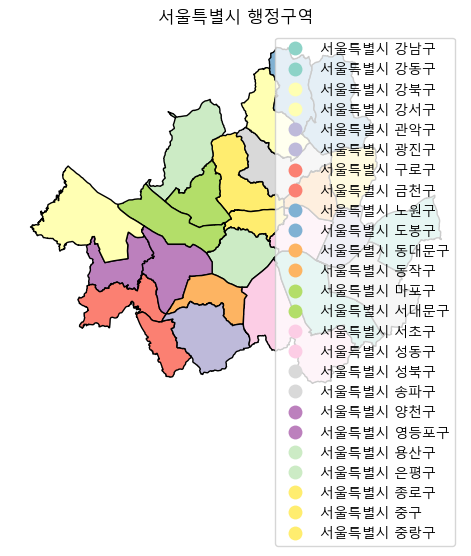

In [4]:
# 지도 시각화
plt.figure(figsize=(10, 10))
gdf.plot(column='SGG_NM', cmap='Set3', edgecolor='black', legend=True)
plt.title('서울특별시 행정구역')
plt.axis('off')
plt.show()

### 1-2. 데이터 불러오기

In [5]:
# 1. 구 경계 데이터 (shp 파일) 불러오기
gdf = gpd.read_file \
    ('../4.Public_transportation/LARD_ADM_SECT_SGG_gu/LARD_ADM_SECT_SGG_11_202405.shp')

In [6]:
# 2. 버스정류장 데이터 로드
bus_stops = pd.read_csv('../4.Public_transportation/Bus_stop_latitude_and_longitude.csv')

### 1-3. 버스정류소 데이터를 GeoDataFrame으로 변환

In [7]:
# Point 객체로 변환
geometry = [Point(xy) for xy in zip(bus_stops['longitude'], bus_stops['latitude'])]

# GeoDataFrame 생성 (WGS 84 좌표계)
bus_stops_gdf = gpd.GeoDataFrame(bus_stops, geometry=geometry, crs="EPSG:4326")

# 좌표계를 서울시 구 경계 데이터에 맞춤 (Korea Central Belt 2010)
bus_stops_gdf = bus_stops_gdf.to_crs(gdf.crs)

### 1-4. 버스정류소와 구 경계 데이터 공간 연산

In [8]:
# Spatial Join (버스정류소와 구 경계 데이터 결합)
joined = gpd.sjoin(bus_stops_gdf, gdf, how="inner", op="within")

# 구별 버스정류소 개수 계산
bus_stop_counts = joined.groupby('SGG_NM').size().reset_index(name='Bus_Stop_Count')

# 결과 출력
print(bus_stop_counts)


        SGG_NM  Bus_Stop_Count
0    서울특별시 강남구             558
1    서울특별시 강동구             403
2    서울특별시 강북구             413
3    서울특별시 강서구             622
4    서울특별시 관악구             490
5    서울특별시 광진구             293
6    서울특별시 구로구             509
7    서울특별시 금천구             355
8    서울특별시 노원구             522
9    서울특별시 도봉구             362
10  서울특별시 동대문구             316
11   서울특별시 동작구             449
12   서울특별시 마포구             587
13  서울특별시 서대문구             463
14   서울특별시 서초구             655
15   서울특별시 성동구             457
16   서울특별시 성북구             598
17   서울특별시 송파구             506
18   서울특별시 양천구             336
19  서울특별시 영등포구             516
20   서울특별시 용산구             353
21   서울특별시 은평구             507
22   서울특별시 종로구             391
23    서울특별시 중구             229
24   서울특별시 중랑구             386


c:\Users\human\.conda\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


### 1-5. 결과 시각화

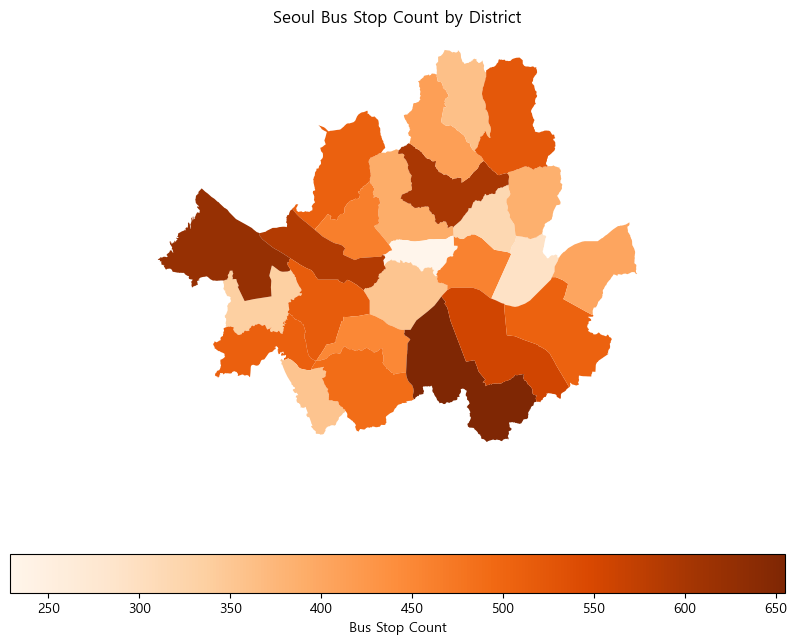

In [9]:
# 구 경계 데이터에 정류소 개수 병합
gdf = gdf.merge(bus_stop_counts, how="left", left_on="SGG_NM", right_on="SGG_NM")
gdf['Bus_Stop_Count'] = gdf['Bus_Stop_Count'].fillna(0)  # 정류소가 없는 경우 0으로 대체

# 지도 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='Bus_Stop_Count', ax=ax, legend=True, cmap='Oranges', 
         legend_kwds={'label': "Bus Stop Count", 'orientation': "horizontal"})
ax.set_title("Seoul Bus Stop Count by District")
ax.axis('off')
plt.show()


### 1-6. 결과 저장

In [10]:
bus_stop_counts.to_csv('Data_Preprocessing/4_Bus_stop_counts_by_gu.csv', index=False)

# 2. 동별 버스정류장 갯수

### 2-1. 서울시 동 경계 데이터 확인

In [11]:
dong_gdf = gpd.read_file \
    ('../4.Public_transportation/BND_ADM_DONG_PG_dong/BND_ADM_DONG_PG.shp', encoding="CP949")

# 데이터 기본 정보 확인
print("데이터 형태:", dong_gdf.shape)
print("/n컬럼 목록:")
print(dong_gdf.columns)

# 처음 몇 행 출력
print("/n데이터 미리보기:")
print(dong_gdf.head())

# 좌표계 정보
print("/n좌표계 정보:")
print(dong_gdf.crs)

# 지리적 범위
print("/n지리적 범위:")
print(dong_gdf.total_bounds)

데이터 형태: (3528, 4)
/n컬럼 목록:
Index(['BASE_DATE', 'ADM_NM', 'ADM_CD', 'geometry'], dtype='object')
/n데이터 미리보기:
  BASE_DATE ADM_NM    ADM_CD  \
0  20230701    사직동  11010530   
1  20230701    삼청동  11010540   
2  20230701    부암동  11010550   
3  20230701    평창동  11010560   
4  20230701    한남동  11030740   

                                            geometry  
0  POLYGON ((197702.069 553187.311, 197703.431 55...  
1  POLYGON ((198170.457 553770.678, 198172.189 55...  
2  POLYGON ((196621.023 556395.880, 196628.323 55...  
3  POLYGON ((197800.719 559064.245, 197782.581 55...  
4  POLYGON ((200404.268 550031.323, 200404.019 55...  
/n좌표계 정보:
PROJCS["Korea_2000_Korea_Central_Belt_2010",GEOGCS["GCS_Korea_2000",DATUM["Korean_Geodetic_Datum_2002",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6737"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",127],PA

### 2-2 데이터 불러오기

In [12]:
# 동 경계 데이터 불러오기
dong_gdf = gpd.read_file \
    ('../4.Public_transportation/BND_ADM_DONG_PG_dong/BND_ADM_DONG_PG.shp', encoding="CP949")

In [13]:
# 버스 정류소 좌표 데이터 읽기
bus_stops = pd.read_csv('../4.Public_transportation/Bus_stop_latitude_and_longitude.csv')

### 2-3. 버스정류소 데이터를 GeoDataFrame으로 변환

In [14]:
# Point 객체로 변환
bus_stops['geometry'] = bus_stops.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)

# GeoDataFrame 생성 (WGS 84 좌표계)
bus_stops_gdf = gpd.GeoDataFrame(bus_stops, geometry='geometry', crs="EPSG:4326")

# 좌표계를 동 경계 데이터에 맞춤 (Korea Central Belt 2010)
bus_stops_gdf = bus_stops_gdf.to_crs(dong_gdf.crs)


### 2-4. Spatial Join을 통한 동별 할당

In [15]:
# Spatial Join
joined = gpd.sjoin(bus_stops_gdf, dong_gdf, how="inner", op="within")

# 동별 버스정류소 개수 계산
dong_bus_counts = joined.groupby('ADM_NM').size().reset_index(name='Bus_Stop_Count')

# 결과 확인
print(dong_bus_counts)

    ADM_NM  Bus_Stop_Count
0     가락1동              14
1     가락2동              21
2     가락본동              25
3     가리봉동               9
4      가산동             105
..     ...             ...
428    효창동              15
429    후암동              18
430   휘경1동              14
431   휘경2동              17
432    흑석동              48

[433 rows x 2 columns]


c:\Users\human\.conda\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


### 2-5. 결과 시각화

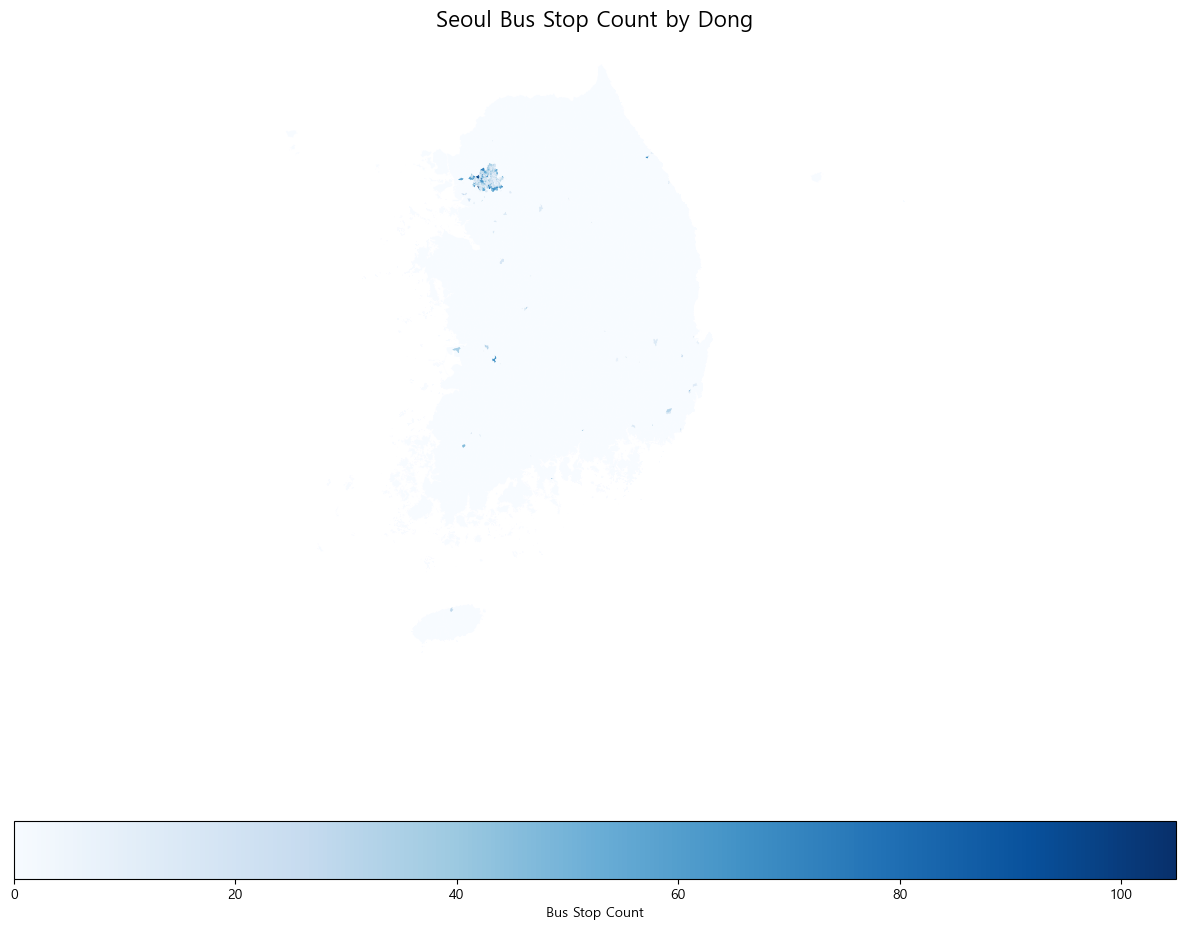

In [16]:
# 동 경계 데이터에 정류소 개수 병합
dong_gdf = dong_gdf.merge(dong_bus_counts, how="left", left_on="ADM_NM", right_on="ADM_NM")
dong_gdf['Bus_Stop_Count'] = dong_gdf['Bus_Stop_Count'].fillna(0)  # 정류소가 없는 경우 0으로 대체

# 지도 시각화
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
dong_gdf.plot(column='Bus_Stop_Count', ax=ax, legend=True, cmap='Blues',
              legend_kwds={'label': "Bus Stop Count", 'orientation': "horizontal"})
ax.set_title("Seoul Bus Stop Count by Dong", fontsize=16)
ax.axis('off')
plt.show()


### 2-6. 결과 저장

In [17]:
dong_bus_counts.to_csv('Data_Preprocessing/4_Bus_stop_counts_by_dong_.csv', index=False)
dong_bus_counts.columns = ['sub_district', 'Bus_Stop_Count']
dong_bus_counts.info(), dong_bus_counts['Bus_Stop_Count'].sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sub_district    433 non-null    object
 1   Bus_Stop_Count  433 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.9+ KB


(None, 11290)

### 2-7. 실제 행정동에 적용

##### 2-7-1. 데이터 불러오기

In [18]:
# 서울시 행정동 목록 불러오기
sd_df = pd.read_csv('subdistrict_list.csv', encoding='CP949')

# 컬럼명 조정
sd_df.columns = ['sub_district']

# 데이터 확인
sd_df.info(), sd_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sub_district  426 non-null    object
dtypes: object(1)
memory usage: 3.5+ KB


(None,
   sub_district
 0          신사동
 1         논현1동
 2         논현2동
 3         압구정동
 4          청담동)

##### 2-7-2. 동이름 비교하기

In [19]:
# 두 데이터프레임의 동이름 비교
print("버스정류장 데이터에 없는 동:", 
      set(sd_df['sub_district']) - set(dong_bus_counts['sub_district']))
print("\n행정동 데이터에 없는 동:", 
      set(dong_bus_counts['sub_district']) - set(sd_df['sub_district']))

버스정류장 데이터에 없는 동: set()

행정동 데이터에 없는 동: {'석수1동', '소하1동', '하안3동', '초이동', '청천2동', '철산1동', '장암동', '미사1동'}


##### 2-7-3. 이상치 처리 (중복 동, 경기도에 속한 동 처리하기)

2-7-3-1. 중복 동 처리

In [20]:
# 중복 동 확인
print("dong_bus_counts 중복된 동이름:")
print(dong_bus_counts['sub_district'][dong_bus_counts['sub_district'].duplicated()])

print("\nsd_df 중복된 동이름:")
print(sd_df['sub_district'][sd_df['sub_district'].duplicated()])

# 정류장 개수 확인
print(dong_bus_counts.loc[dong_bus_counts['sub_district'] == '신사동'], '\n\n')

# 기존 신사동 데이터 제거
dong_bus_counts = dong_bus_counts[dong_bus_counts['sub_district'] != '신사동']

# 2개 행으로 나눠서 값 분배
new_rows = pd.DataFrame([
    {'sub_district': '신사동', 'Bus_Stop_Count': 17},
    {'sub_district': '신사동', 'Bus_Stop_Count': 17}
])

# 새 데이터 추가
dong_bus_counts = pd.concat([dong_bus_counts, new_rows])

# 결과 확인
print(dong_bus_counts[dong_bus_counts['sub_district'].str.contains('신사동')])
dong_bus_counts.info()

dong_bus_counts 중복된 동이름:
Series([], Name: sub_district, dtype: object)

sd_df 중복된 동이름:
88    신사동
Name: sub_district, dtype: object
    sub_district  Bus_Stop_Count
249          신사동              34 


  sub_district  Bus_Stop_Count
0          신사동              17
1          신사동              17
<class 'pandas.core.frame.DataFrame'>
Index: 434 entries, 0 to 1
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sub_district    434 non-null    object
 1   Bus_Stop_Count  434 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.2+ KB


2-7-3-2. 서울시 외의 동 정보 확인

In [21]:
# 서울시 외 동 이름
non_seoul_dongs = {'장암동', '철산1동', '소하1동', '하안3동', '미사1동', '초이동', '석수1동', '청천2동'}

# 서울시 외 동들의 버스 정류장 합계
non_seoul_bus_stops = dong_bus_counts[dong_bus_counts['sub_district'].isin(non_seoul_dongs)]['Bus_Stop_Count'].sum()
print(f"서울시 외 동에 있는 버스정류장 개수: {non_seoul_bus_stops}")

서울시 외 동에 있는 버스정류장 개수: 10


2-7-3-3. 서울시 정보 확인

In [22]:
# 서울시 버스 정류장 수
total_bus_stops = 11290
seoul_bus_stops = total_bus_stops - non_seoul_bus_stops

# 서울시 데이터 필터링
seoul_dong_bus_counts = dong_bus_counts[~dong_bus_counts['sub_district'].isin(non_seoul_dongs)]

# 결과 출력
print(f"서울시 버스정류장 총 개수: {seoul_bus_stops}")
print("\n서울시 동별 버스정류장 개수:")
print(seoul_dong_bus_counts)

서울시 버스정류장 총 개수: 11280

서울시 동별 버스정류장 개수:
    sub_district  Bus_Stop_Count
0           가락1동              14
1           가락2동              21
2           가락본동              25
3           가리봉동               9
4            가산동             105
..           ...             ...
430         휘경1동              14
431         휘경2동              17
432          흑석동              48
0            신사동              17
1            신사동              17

[426 rows x 2 columns]


In [26]:
seoul_dong_bus_counts.info(), dong_bus_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 426 entries, 0 to 1
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sub_district    426 non-null    object
 1   Bus_Stop_Count  426 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 434 entries, 0 to 1
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sub_district    434 non-null    object
 1   Bus_Stop_Count  434 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.2+ KB


(None, None)

##### 2-8. 결과 저장

In [27]:
seoul_dong_bus_counts.to_csv('Data_Preprocessing/4_Bus_stop_counts_by_dong.csv', index=False)